In [2]:
import os
import requests
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from io import StringIO
import pprint as pp
import json
import re
from datetime import datetime, timedelta
from scipy import interpolate
from scipy.interpolate import CubicSpline

<b>Get data per day</b>

In [3]:
KNMI_BASE_URL_daydata = 'https://www.daggegevens.knmi.nl/klimatologie/daggegevens'
params_daydata = {'stns': '235:280:260', 'vars': 'WIND', 'byear': '2021', 'bmonth': '11', 'bday': '1', 'eyear': '2021', 'emonth': '11', 'eday': '29', 'fmt':'json'}
params_daydata_incl_doc = {'stns': '235:280:260', 'vars': 'WIND', 'byear': '2021', 'bmonth': '11', 'bday': '1', 'eyear': '2021', 'emonth': '11', 'eday': '29', 'fmt':'csv'}  #if 'fmt' is set to 'csv', the API will also return the documentation of the returned variables
std_params_data_weatherstations = {'stns': 'ALL', 'vars': 'WIND', 'byear': '2021', 'bmonth': '11', 'bday': '1', 'eyear': '2021', 'emonth': '11', 'eday': '01', 'fmt':'csv'}

In [4]:
def get_access_KNMI_daydata_with_doc(url: str, params: str) -> str:
    '''
    Function calls the KNMI API with certain parameters and returns the whole output,
    incl. the documentation of the different output variables
    '''
    response = requests.post(url=url, data=params)
    return response.text

In [ ]:
print(get_access_KNMI_daydata_with_doc(KNMI_BASE_URL_daydata, params_daydata_incl_doc))

In [5]:
def get_access_KNMI_daydata(url: str, params: str) -> list:
    '''
    Function calls the KNMI API with certain parameters and returns the output,
    without the documentation of the different output variables. The returned list includes
    dicts where every dict contains a name-value pair for the weather data of one weather station
    for one day
    '''
    response = requests.post(url=url, data=params)
    return response.json()

In [ ]:
pp.pprint(get_access_KNMI_daydata(KNMI_BASE_URL_daydata, params_daydata))

<b>Get data about weatherstations</b>

In [6]:
def get_access_KNMI_data_weatherstations(url: str, params: str) -> list:
    '''
    Function returns the following data features about each weatherstations:
    -Index of weatherstation
    -altitude of weatherstation
    -latitude and longitude coordinates of location of weather station
    -name of weatherstation (city where weaatherstation is located)
    
    The function returns a list, whereby each element of this list is a dict with the already mentioned
    data features for a single weatherstation
    '''
    response = requests.post(url=url, data=params).text.splitlines()[6:56] #get just data about weather stations from documentation -> data in lines from 6-56
    
    all_weather_stations = []
    for i in range(len(response)):
        single_weather_stations = {}
        
        #To get the names of the weather stations (city names) right, a regex is looking for a pattern where a char is followed by a space and then again followed
        #by a char OR only by a string of chars -> all station names (also the one which include a space) can be filtered
        name = re.search('([a-zA-Z]+(\s*[a-zA-Z])*)', response[i])
        name = name.group()

        #Index '1' = STN number, Index '10' = latitude of single weather station, Index '17' = longitude of single weather station
        #Index '23' = altitude of weather station
        data_single_weather_station = response[i].split(" ")
        index, long, lat, alt = data_single_weather_station[1], data_single_weather_station[10], data_single_weather_station[17], data_single_weather_station[23]
        
        single_weather_stations["index"] = index
        single_weather_stations["long"] = long
        single_weather_stations["lat"] = lat
        single_weather_stations["alt"] = alt
        single_weather_stations["name"] = name
    
        all_weather_stations.append(single_weather_stations)
    return all_weather_stations


In [ ]:
pp.pprint(get_access_KNMI_data_weatherstations(KNMI_BASE_URL_daydata, std_params_data_weatherstations))

<b>Get time series data</b>

In [7]:
SDV_BASE_URL = os.environ['SDV_URL']
SDV_API_PATH = os.environ['SDV_API_PATH']
AUTH_HEADER = os.environ['SDV_AUTH_TOKEN']

In [8]:
def get_network_group_id() -> int:
    '''
    Function returns the Group ID of a specific group 
    in which the user is participating.
    
    WARNING: Function must be editited!! Function currently just takes the ID from the first
    group which is returned from the API. 
    '''
    response = requests.get(
        f'{SDV_BASE_URL}{SDV_API_PATH}/groups/',
        headers={'Authorization': AUTH_HEADER})
    return response.json()[0]['id']

In [9]:
def get_group_data(group_id: int, page=1) -> dict:
    '''
    Function returns the data of all activities for one page (parameter 'page')
    within a specific group (parameter 'group_id'.
    '''
    response = requests.get(
        f'{SDV_BASE_URL}{SDV_API_PATH}/groups/{group_id}/recent_activity',
        headers={'Authorization': AUTH_HEADER},
        params={'page': page})
    return response.json()

In [ ]:
pp.pprint(get_group_data(get_network_group_id(), page=8)['data'][1]['summary'])

In [10]:
def get_activity_from_group_data(group_id: id, activity_index_within_page: id, page=1) -> dict:
    '''
    Function returns the data of one activity (parameter 'activity_index_within_page' from a specific page (parameter 'page')
    within a specific group (parameter 'group_id').
    
    The parameter 'activity_index_within_page' is the number where 
    the activity is listed on the page in the activity list of a group (start counting from the top)
    
    Example: Data of activity number 6 from page 4 from group xyz should be returned
            -> group_id = id of group xyz, activity_index_within_page = 5, page = 4
    '''
    response = requests.get(
        f'{SDV_BASE_URL}{SDV_API_PATH}/groups/{group_id}/recent_activity',
        headers={'Authorization': AUTH_HEADER},
        params={'page': page})
    return response.json()['data'][activity_index_within_page]

In [ ]:
pp.pprint(get_activity_from_group_data(get_network_group_id(), 0, 8))

In [11]:
def get_activity_id_from_group_data(group_id, activity_index_within_page, page=1) -> int:
    '''
    Function returns the ID of a specific activity (parameter 'activity_index_within_page' from a specific page (parameter 'page')
    within a specific group (parameter 'group_id').
    
    The parameter 'activity_index_within_page' is the number where 
    the activity is listed on the page in the activity list of a group (start counting from the top)
    
    Example: ID of activity number 6 from page 4 from group xyz should be returned
            -> group_id = id of group xyz, activity_index_within_page = 5, page = 4
    '''
    response = requests.get(
        f'{SDV_BASE_URL}{SDV_API_PATH}/groups/{group_id}/recent_activity',
        headers={'Authorization': AUTH_HEADER},
        params={'page': page})
    return response.json()['data'][activity_index_within_page]['id']

In [ ]:
pp.pprint(get_activity_id_from_group_data(get_network_group_id(), 0, 8))

In [12]:
def get_timeseries_data_for_activity(activity_id: int) -> dict:
    '''
    Function returns timeseries data for one activity.
    Name value pairs (keys): 
    -offset
    -time_series 
    -elevation
    -latlong
    -speed
    '''
    response = requests.get(
        f'{SDV_BASE_URL}{SDV_API_PATH}/data/{activity_id}/time_series',
        headers={'Authorization': AUTH_HEADER})
    return response.json()

In [ ]:
pp.pprint(get_timeseries_data_for_activity(get_activity_id_from_group_data(get_network_group_id(), 8)))

<b>Transfer data into dataframe for ploting</b>

In [13]:
def get_lat_long_from_timeseries(full_timeseries_data_per_activity: dict, frequency=150) -> pd.DataFrame:  #frequency = steps on how many data points form time series data are taken, per default only each 150th entry is taken
    '''
    Transform 'latlong' values of timeseries data of one activity into a DataFrame element.
    Via the parameter 'frequency' it can be controlled how many data points are taken into account 
    to lower the overall needed computing power and to reduce runtime.
    E.g., 'frequency=150' means that only each 150th data point is taken into account
    '''
    long_lat_timeseries_data_for_activity = full_timeseries_data_per_activity['time_series']['latlong']  #take just long and lat coordinates from timeseries data
    shortened_timeseries_data_per_activity = {}
    global lat
    global long
    lat = []
    long = []
    for i in range(0, len(long_lat_timeseries_data_for_activity), frequency):   #takes per default only each 150th entry from timeseries data to make plot more clear; to make graph more precise reduce 'increment rate'
        lat.append(long_lat_timeseries_data_for_activity[i][0])
        long.append(long_lat_timeseries_data_for_activity[i][1])

    shortened_timeseries_data_per_activity["lat"] = lat
    shortened_timeseries_data_per_activity["long"] = long

    return pd.DataFrame.from_dict(shortened_timeseries_data_per_activity)


In [ ]:
pp.pprint(get_lat_long_from_timeseries(get_timeseries_data_for_activity(get_activity_id_from_group_data(get_network_group_id(), 8))))

<b>Get closest weather station to each timeseries point</b>

In [14]:
def assign_closest_weather_station_to_latlong_coord(lat_coord: float, long_coord: float) -> dict:
    '''
    Calculate the closest weather station for a latlong coordinate.
    Return the data features of that weatherstation (e.g. latlong coordinates or altitude of weather station)
    '''
    data_weather_stations = get_access_KNMI_data_weatherstations(KNMI_BASE_URL_daydata, std_params_data_weatherstations)  #returns the data features of all weatherstations (e.g. latlong coordinates or altitude of weather station) 
    #Iterate over each weather station
    shortest_distance = 1000
    closest_weather_station_index = -1 #index of weatherstation in dict 'data_weather_stations'
    
    for i in range(len(data_weather_stations)):
        lat_weather_station, long_weather_station = float(data_weather_stations[i]['lat']), float(data_weather_stations[i]['long'])
        lat_diff, long_diff = np.sqrt((lat_coord - lat_weather_station)**2), np.sqrt((long_coord - long_weather_station)**2) #make distances positive
        total_dist = np.sqrt(lat_diff**2 + long_diff**2) #use Pythagoras to calculate distance

        if (total_dist <= shortest_distance):
            shortest_distance = total_dist
            closest_weather_station_index = i
            
    return(data_weather_stations[closest_weather_station_index])

In [ ]:
print(assign_closest_weather_station_to_latlong_coord(52.303421, 5.144409))

<b>Iterate over all timeseries points and get IDs of closest weather stations</b>

In [15]:
#get closest weather stations to each timeseries point
def get_closest_weather_stations_to_each_timeseries_point(df: pd.DataFrame):
    '''
    Calculates the closest weather stations of an activity.
    Parameter 'df' must be a Data Frame with lat and long coordinates.
    Function returns two lists, whereby the list 'idx_closest_weather_stations' contains the indizes of the closest weather stations (all indizes appear just once in the list)
    and the list 'closest_weather_stations' contains the data features of the closest weather stations as a dict (data features for one weather station appear just once in the list).
    
    Returns: list, list
    '''
    long = df['long'].values
    lat = df['lat'].values
    closest_weather_stations = []
    idx_closest_weather_stations = []
    for i in range(len(long)):
        weather_station = assign_closest_weather_station_to_latlong_coord(lat[i], long[i])
        weather_station_id = weather_station['index']

        counter = 0 #check if index already exists
        for j in range(len(closest_weather_stations)):
            if (closest_weather_stations[j]['index'] == weather_station_id):
                counter += 1

        if (counter == 0):
            closest_weather_stations.append(weather_station)
            idx_closest_weather_stations.append(weather_station_id)
        
    return idx_closest_weather_stations, closest_weather_stations

<b>Transform wind direction from degrees to 'coordinates'</b>

In [16]:
def transform_degree(wind_direction_in_degree: int, constant_hypotenuse: float):
    '''
    Calculates the Cartesian Coordinates dx and dy to determine the wind direction for the ploting.
    
    Returns: float, float
    '''
    #original formula for Cartesian Coordinate dx = hypotenuse × cos(degree) -> changed to sin() because 0 degree is here on point x = 0, y = 1 and not on x = 1, y = 0
    #original formula for Cartesian Coordinate dy = hypotenuse × sin(degree) -> changed to cos() because 0 degree is here on point x = 0, y = 1 and not on x = 1, y = 0
    wind_direction_in_degree = np.deg2rad(wind_direction_in_degree)
    dx = constant_hypotenuse * np.sin(wind_direction_in_degree)  
    dy = constant_hypotenuse * np.cos(wind_direction_in_degree)  
    return dx, dy

<b>Plot timeseries data with closest weather stations and direction of wind for SINGLE activity</b>

In [17]:
def plot_cycling_path_for_single_activity(page: int, activity_num: int, frequency: int) -> None:
    '''
    Plot the cycling path from an specific activity (parameter 'activity_num', start counting from top)
    from a specific page (parameter 'page'). Also, plot the location of the closest weather stations to the activity and the measured wind direction (just on daily basis!).
    The parameter 'frequency' describes the precision and the runtime of the plot (the lower the frequency, the more latlong coordinates are taken into account, the longer the runtime).
    
    WARNING: Currently, the ploted wind direction is a 'daily' measurement, so it's the mean wind direction from the whole day, not the wind direction which was measured while the 
    cycling was done!
    '''
    network_group_id = get_network_group_id()
    df_lat_long = get_lat_long_from_timeseries(get_timeseries_data_for_activity(get_activity_id_from_group_data(network_group_id, activity_num, page)), frequency = frequency)
    idx_closest_weather_stations, closest_weather_stations = get_closest_weather_stations_to_each_timeseries_point(df_lat_long)
    stns = ':'.join(idx_closest_weather_stations) #join indizes from weather stations in format 'xxx:yyy:zzz' to use them as parameter input for the KNMI API
    activity_date = datetime.fromisoformat(get_activity_from_group_data(network_group_id, activity_num, page)['metadatum']['event_start'][:10])  #only YYYY-MM-DD format
    print(activity_date)                        

    params_daydata = {'stns': str(stns), 'vars': 'WIND', 'byear': activity_date.year, 'bmonth': activity_date.month, 'bday': activity_date.day, 
                     'eyear': activity_date.year, 'emonth': activity_date.month, 'eday': activity_date.day, 'fmt':'json'}

    u = np.diff(long)
    v = np.diff(lat)
    pos_long = long[:-1] + u/2
    pos_lat = lat[:-1] + v/2
    norm = np.sqrt(u**2+v**2) 


    #cycling path
    fig, ax = plt.subplots()
    ax.plot(long, lat)
    ax.quiver(pos_long, pos_lat, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", headwidth=5)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Cycling direction with wind direction')


    #weather stations
    for i in range(len(closest_weather_stations)):
        #combine location data from weather station with weather data from weather staiton
        for j in range(len(get_access_KNMI_daydata(KNMI_BASE_URL_daydata, params_daydata))):
            if (str(closest_weather_stations[i]['index']) == str(get_access_KNMI_daydata(KNMI_BASE_URL_daydata, params_daydata)[j]['station_code'])):
                wind_direction_in_degree = get_access_KNMI_daydata(KNMI_BASE_URL_daydata, params_daydata)[j]['DDVEC']
                print("wind_direction_in_degree: " + str(wind_direction_in_degree))
                #sometimes wind data is not available, then 'None' is returned; filter to prevent issues with funtcion 'transform_degree()', which requires 'int' as input
                if wind_direction_in_degree is not None:
                    dx, dy = transform_degree(wind_direction_in_degree, 0.01)
                    #plt.arrow(float(closest_weather_stations[i]['long']), float(closest_weather_stations[i]['lat']), float(dx), float(dy), head_width = 0.01, width = 0.01) -> arrows where the size depends on the scale of the axes
                    plt.quiver(float(closest_weather_stations[i]['long']), float(closest_weather_stations[i]['lat']), float(dx), float(dy), color='b') # -> quiver arrows


    plt.show()

<b>Plot timeseries data with closest weather stations and direction of wind for ALL activities</b>

In [18]:
def get_number_pages(group_id: int) -> int:   #get all activities from group
    '''
    Return the amount of pages with activities within a group.
    '''
    response = requests.get(
        f'{SDV_BASE_URL}{SDV_API_PATH}/groups/{group_id}/recent_activity',
        headers={'Authorization': AUTH_HEADER})
    return response.json()['page']['total_pages']

In [ ]:
'''
Plot all cycling activities which were conducted in the Netherlands and for which time series data is available
'''

network_group_id = get_network_group_id()

#iteration over all activity pages in group
for page in range (1, get_number_pages(network_group_id)+1):
    #iteration over all activities within one page
    for activity_num in range (len(get_group_data(network_group_id, page)['data'])):
        activity = get_group_data(network_group_id, page)['data'][activity_num]['summary']
        
        #filter only real sport activities -> coding activities (.ipynb files) are ignored (they return 'None' for the variable 'activitiy')
        if activity is not None:
            try:
                latlong_start = activity['time_series_summaries']['latlong']['start'] 
            except:
                latlong_start = None
                
            if latlong_start is not None:

                #filter only activities from the Netherlands/Amsterdam (some activities don't have 'tz' data)
                #50,75 is most southern lat-coord. in the Netherlands
                #53.5 is most northern lat-coord. in the Netherlands
                #3.37 is most western long-coord. in the Netherlands
                #7.2 is most eastern long-coord. in the Netherlands
                if latlong_start[0] >= 50.75 and latlong_start[0] <= 53.5 and latlong_start[1] >= 3.37 and latlong_start[1] <= 7.2:

                    #test if long and lat timeseries coordinates for activity are available, if not, continue with next activity
                    try:
                        df_lat_long = get_lat_long_from_timeseries(get_timeseries_data_for_activity(get_activity_id_from_group_data(network_group_id, activity_num, page)))
                    except:
                        print("Page: " + str(page) + " Activity: " + str(activity_num) + " -> No time series lat long coords available for that activity!")
                        df_lat_long = None
                    
                    if df_lat_long is not None:

                        idx_closest_weather_stations, closest_weather_stations = get_closest_weather_stations_to_each_timeseries_point(df_lat_long)
                        stns = ':'.join(idx_closest_weather_stations) #join indizes from weather stations in format 'xxx:yyy:zzz'
                        activity_date = datetime.fromisoformat(get_activity_from_group_data(network_group_id, activity_num, page)['metadatum']['event_start'][:10])  #only YYYY-MM-DD format
                        print(activity_date)

                        params_daydata = {'stns': str(stns), 'vars': 'WIND', 'byear': activity_date.year, 'bmonth': activity_date.month, 'bday': activity_date.day, 
                                          'eyear': activity_date.year, 'emonth': activity_date.month, 'eday': activity_date.day, 'fmt':'json'}

                        #vars 'long' and 'lat' are set globally in function 'get_lat_long_from_timeseries()'
                        u = np.diff(long)
                        v = np.diff(lat)
                        pos_long = long[:-1] + u/2
                        pos_lat = lat[:-1] + v/2
                        norm = np.sqrt(u**2+v**2) 

                        #cycling path
                        fig, ax = plt.subplots()
                        ax.plot(long, lat)
                        ax.quiver(pos_long, pos_lat, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", headwidth=5)
                        plt.xlabel('Longitude')
                        plt.ylabel('Latitude')
                        plt.title('Cycling direction with wind direction')


                        #weather stations
                        for i in range(len(closest_weather_stations)):
                            #combine location data from weather station with weather data from weather staiton
                            for j in range(len(get_access_KNMI_daydata(KNMI_BASE_URL_daydata, params_daydata))):
                                if (str(closest_weather_stations[i]['index']) == str(get_access_KNMI_daydata(KNMI_BASE_URL_daydata, params_daydata)[j]['station_code'])):
                                    wind_direction_in_degree = get_access_KNMI_daydata(KNMI_BASE_URL_daydata, params_daydata)[j]['DDVEC']
                                    print("wind_direction_in_degree: " + str(wind_direction_in_degree))
                                    #sometimes wind data is not available, then None is returned; filter to prevent issues with funtcion 'transform_degree()', which requires 'int' as input
                                    if wind_direction_in_degree is not None:
                                        dx, dy = transform_degree(wind_direction_in_degree, 0.01)
                                        #plt.arrow(float(closest_weather_stations[i]['long']), float(closest_weather_stations[i]['lat']), float(dx), float(dy), head_width = 0.01, width = 0.01)
                                        plt.quiver(float(closest_weather_stations[i]['long']), float(closest_weather_stations[i]['lat']), float(dx), float(dy), color='b')

                        plt.show()

<b>Determine and plot cycling speed and HOURLY wind influence from closest weather stations and direction of wind for SINGLE activity</b>

In [19]:
#get closest weather stations to each timeseries point and save weather stations for all timeseries points (even if they're doubled)
def get_closest_weather_stations_for_each_timeseries_point_COMPLETE(df: pd.DataFrame):   #df = data frame which consists of long ant lat coordinates
    '''
    Calculates the closest weather stations FOR EACH time series point of an activity.
    Parameter 'df' must be a Data Frame with lat and long coordinates.
    Function returns two lists, whereby the list 'idx_closest_weather_stations' contains all indizes of the closest weather stations 
    and the list 'closest_weather_stations' contains the data features of the closest weather stations as a dict.
    
    Example and difference to function 'get_closest_weather_stations_to_each_timeseries_point': 
    df = Data Frame with 10 latlong data points 
    
        -> list 'idx_closest_weather_stations' contains 10 indizes, 
        whereby value at position 0 represents the index of the weather station which is the closetst to the longlat coordinate at position 0 in the Data Frame
        
        -> list 'closest_weather_stations' contains 10 dicts, 
        whereby the dict at position 0 represents the data features of the weather station which is the closetst to the longlat coordinate at position 0 in the Data Frame
        
    Returns: list, list
    '''
    long = df['long'].values
    lat = df['lat'].values
    closest_weather_stations = []
    idx_closest_weather_stations = []
    for i in range(len(long)):
        weather_station = assign_closest_weather_station_to_latlong_coord(lat[i], long[i])
        weather_station_id = weather_station['index']

        counter = 0 #check if index already exists
        for j in range(len(closest_weather_stations)):
            if (closest_weather_stations[j]['index'] == weather_station_id):
                counter += 1

        if (counter == 0):
            idx_closest_weather_stations.append(weather_station_id)
        
        closest_weather_stations.append(weather_station) #assign to each timeseries point the closest weather station
        
    return idx_closest_weather_stations, closest_weather_stations

In [20]:
#std parameters to get standard data about weatherstations (long, lat coord, altitude, etc.)
KNMI_BASE_URL_daydata = 'https://www.daggegevens.knmi.nl/klimatologie/daggegevens'
std_params_data_weatherstations = {'stns': 'ALL', 'vars': 'WIND', 'byear': '2021', 'bmonth': '11', 'bday': '1', 'eyear': '2021', 'emonth': '11', 'eday': '01', 'fmt':'csv'}

#get hourly weather data from weather stations
KNMI_BASE_URL_hourly_data = 'https://www.daggegevens.knmi.nl/klimatologie/uurgegevens'
params_hourly_data = {'stns': '240:260:249:248:235', 'vars': 'WIND', 'byear': '2021', 'bmonth': '7', 'bday': '24', 'bhour': '8', 'eyear': '2021', 'emonth': '7', 'eday': '24', 'ehour': '14', 'fmt':'json'}
#235:280:260

In [ ]:
pp.pprint(get_access_KNMI_daydata(KNMI_BASE_URL_hourly_data, params_hourly_data))

In [21]:
def calculate_time_stamps_for_ts_points(activity_start: datetime.date, distance: list, avg_cycling_speed_activitiy: float) -> list:
    '''
    Problem: in the timeseries data of the activities are no timestamps for the single entries provided, only the distance and speed for each timeseries entry.
    To match the exact wind data timewise to the exact cycling data, this function calculates based on the avg. speed and the 'margins' between the different 
    distance entries the timestamp for the different timeseries entries.
    
    Example: The activity start was at 08:30 AM, the avg. speed was 20 km/h and between timeseries entry 0 and timeseries entry 1 the cyclist covered a distance of 100 meters
            -> time needed for the 100 meter = 0.1/20 = 0.005 h = 0.3 minutes = 18 seconds -> timestamp for timeseries point 1 = 08:30:18 AM
    '''
    time_stamps = []
    time_stamps.append(activity_start)
    diff_distance = np.diff(distance)
    for i in range (len(diff_distance)):
        h = diff_distance[i]/avg_cycling_speed_activitiy
        time_stamps.append(time_stamps[i] + timedelta(hours=h))
    return time_stamps

In [22]:
def determine_headwind_tailwind_periods(page: int, activity_num: int, frequency=20):
    '''
    ATTENTION: 
    1) Calling funtion can last a couple of minutes based on the frequency and the length of the activity!
    2) For some activities there is no timeseries data available! Unfortunately, the funtion doesn't work for those activities!
    3) For dates there is no wind data provided from the API. If thats the case the funtion will return an error!
    
    Parameter 'page' represents the page number where the acitivity is listed
    Parameter 'activity_num' represents the index where the activity is listed on specific page
    Parameter 'frequency' describes how many timeseries points are taken into account (e.g., 'frequency' = 150 -> only each 150th timeseries point will be taken into account
               -> reduces runtime and makes plot more clear, but is less precise
               
    PART 1: Get access to the SDV API and get timeseries data
    PART 2: Get access to the KNMI API and assign closest weather stations for each timeseries point at the right time (hourly basis)
    PART 3: Determine headwind/tailwind periods for specific cycling activity

    Returns: list, list
    '''
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #PART 1
    
    network_group_id = get_network_group_id()
    activity = get_group_data(network_group_id, page)['data'][activity_num]['summary']

    timeseries_data = get_timeseries_data_for_activity(get_activity_id_from_group_data(network_group_id, activity_num, page))['time_series']

    df_lat_long = get_lat_long_from_timeseries(get_timeseries_data_for_activity(get_activity_id_from_group_data(network_group_id, activity_num, page)), frequency)

    #take just each element of a timeseries array which is given via the variable 'frequency' to reduce the needed processing units
    global distance
    global cycling_speed
    distance = np.array(timeseries_data['distance'][::frequency])/1000    #divide by 1000 to get data in km
    cycling_speed = np.array(timeseries_data['speed'][::frequency])*3.6   #in timeseries data the cycling speed is given in meters per second -> to convert to km/h it has to be multiplied by 3.6 -> (meters per sec*60*60)/1000
    
    #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #PART 2
    
    #variable 'closest_weather_stations_for_each_ts_point' contains the index of the closest weather station for each timeseries point (ts)
    idx_closest_weather_stations, closest_weather_stations_for_each_ts_point = get_closest_weather_stations_for_each_timeseries_point_COMPLETE(df_lat_long)
    stns = ':'.join(idx_closest_weather_stations) #join indizes from weather stations in format 'xxx:yyy:zzz'
    activity_date_start = datetime.fromisoformat(get_activity_from_group_data(network_group_id, activity_num, page)['metadatum']['event_start'])
    activity_date_end = datetime.fromisoformat(get_activity_from_group_data(network_group_id, activity_num, page)['metadatum']['event_end'])
    
    #'activity_date_end.hour + 1' -> calculated the end hour + 1, bc if activity ends at 13:45 for instance, 'activity_date_end.hour' will only return
    #a 13, so the 45 minutes after 1PM are not recognized, therefore I calculate +1 so that I also get the full hour from 1PM to 2PM
    params_hourly_daydata = {'stns': str(stns), 'vars': 'WIND', 'byear': activity_date_start.year, 'bmonth': activity_date_start.month,
                            'bday': activity_date_start.day, 'bhour': activity_date_start.hour, 'eyear': activity_date_end.year, 'emonth': activity_date_end.month, 
                            'eday': activity_date_end.day, 'ehour': activity_date_end.hour + 1, 'fmt':'json'}
    
    #get HOURLY daydata from weatherstations
    closest_weather_stations_for_activity = get_access_KNMI_daydata(KNMI_BASE_URL_hourly_data, params_hourly_daydata)
    wind_directions_for_each_timeseries_point = []   #dx, dy coordinates of wind direction from weather stations
    wind_speed_for_each_timeseries_point = [] 

    #vars 'long' and 'lat' are set globally in function 'get_lat_long_from_timeseries()'
    #differences between n and n+1 element in array 'latL and 'long' to get dx and dy values
    u = np.diff(long)
    v = np.diff(lat)

    #create list with elements (dx, dy) 
    cycling_directions_for_each_timeseries_point = []
    for i in range(len(u)):
        cycling_directions_for_each_timeseries_point.append((u[i], v[i]))
        
    #calculate for each ts point the approx. time stamp to assign the coorect time measure of the weather station
    avg_cycling_speed_activitiy = get_activity_from_group_data(network_group_id, 9, 1)['summary']['avg_speed'] * 3.6  #in activity data the cycling speed is given in meters per second -> to convert to km/h it has to be multiplied by 3.6 -> (meters per sec*60*60)/1000
    time_stamps = calculate_time_stamps_for_ts_points(activity_date_start, distance, avg_cycling_speed_activitiy)
    
    all_idx_closest_weather_stations = []
    #get wind speed for each ts point and wind direction for each ts point
    for i in range(len(closest_weather_stations_for_each_ts_point)):
        idx_closest_weather_station_for_timeseries_point = closest_weather_stations_for_each_ts_point[i]['index']
        all_idx_closest_weather_stations.append(idx_closest_weather_station_for_timeseries_point)
        for j in range(len(closest_weather_stations_for_activity)):
            
            #only if the index of the weather station from the current iteration matches the correct weather station (same index) AT THE RIGHT TIME
            if (str(idx_closest_weather_station_for_timeseries_point) == str(closest_weather_stations_for_activity[j]['station_code'])) and (str(time_stamps[i].hour) == str(closest_weather_stations_for_activity[j]['hour'])):
                wind_speed_for_each_timeseries_point.append(closest_weather_stations_for_activity[j]['FH']) #FH = Hourly mean wind speed (in 0.1 m/s)

                (dx, dy) = transform_degree(closest_weather_stations_for_activity[j]['DD'], 0.01)
                wind_directions_for_each_timeseries_point.append((dx, dy))


    global wind_speed
    wind_speed = np.array(wind_speed_for_each_timeseries_point)*0.36   #data is originally provided as 0.1*m/s -> to transform it into km/h -> *0.1*60*60/1000
    
    #for testing the proper allocation of the hourly data 
    '''
    for i in range(len(distance)):
        a, b, c = all_idx_closest_weather_stations[i], wind_speed[i], time_stamps[i].hour
        print(a, b, c)
    '''
    #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #PART 3
    
    #variables 'tailwind' and 'headwind' are helper variables to detect if the ts point of the last iteration had tailwind (then var 'tailwind' = 1) or had headwind (then var 'headwind' = 1)
    #initialize array 'spans_tailwind' and 'spans_headwind' to safe consecutive ts point where the cyclist had tailwind or headwind
    tailwind = 0
    headwind = 0
    spans_tailwind = []
    spans_headwind = []

    #print(wind_directions_for_each_timeseries_point)
    #iteration over the cycling ts data to detect if cyclist had headwind or tailwind for specific ts point
    for i in range(len(cycling_directions_for_each_timeseries_point)):
        dx_wind = wind_directions_for_each_timeseries_point[i][0]
        dx_cycling = cycling_directions_for_each_timeseries_point[i][0]
        dy_wind = wind_directions_for_each_timeseries_point[i][1]
        dy_cycling = cycling_directions_for_each_timeseries_point[i][1]

        #wind direction and cycling direction are the same on the x and y coordinate
        if (((dx_wind >= 0 and dx_cycling >=0) and (dy_wind >= 0 and dy_cycling >=0)) or
            ((dx_wind <= 0 and dx_cycling <=0) and (dy_wind <= 0 and dy_cycling <=0)) or
            ((dx_wind >= 0 and dx_cycling >=0) and (dy_wind <= 0 and dy_cycling <=0)) or
            ((dx_wind <= 0 and dx_cycling <=0) and (dy_wind >= 0 and dy_cycling >=0))):

            #if first ts point with tailwind -> add new sub-array with distance value (x value in graph later)
            if tailwind == 0:
                spans_tailwind.append([])
                spans_tailwind[len(spans_tailwind)-1].append(distance[i])
            #if consecutive ts point with tailwind -> add only distance value 
            elif tailwind == 1:
                spans_tailwind[len(spans_tailwind)-1].append(distance[i])

            tailwind = 1
            headwind = 0

        #wind direction and cycling direction are contrary on the x and y coordinate
        elif (((dx_wind >= 0 and dx_cycling <=0) and (dy_wind >= 0 and dy_cycling <=0)) or
              ((dx_wind <= 0 and dx_cycling >=0) and (dy_wind <= 0 and dy_cycling >=0)) or
              ((dx_wind >= 0 and dx_cycling <=0) and (dy_wind <= 0 and dy_cycling >=0)) or
              ((dx_wind <= 0 and dx_cycling >=0) and (dy_wind >= 0 and dy_cycling <=0))):
            if headwind == 0:
                spans_headwind.append([])
                spans_headwind[len(spans_headwind)-1].append(distance[i])
            elif headwind == 1:
                spans_headwind[len(spans_headwind)-1].append(distance[i])

            tailwind = 0
            headwind = 1

        else:
            #if no headwind or tailwind detected -> sequence of tailwind or headwind coord is interrupted 
            tailwind = 0
            headwind = 0
    
    return spans_headwind, spans_tailwind

In [23]:
def plot_headwind_tailwind_periods_for_single_activity(spans_headwind, spans_tailwind) -> None:
    '''
    ATTENTION: To use this function, the function 'determine_headwind_tailwind_periods' must be called beforehand, 
    because global variables are needed from that function as well as the input parameters 'spans_headwind' and 'spans_tailwind'.
    
    Input parameters 'spans_headwind' and 'spans_tailwind' are 2D-lists, whereby each sub-list represents a headwind/tailwind period (measured by distance). 
    
    This function plots on the x-axis the cycling distance, on the left y-axis the cycling speed and on the rigth y-axis the wind speed.
    Additionally, in the background of the plot are also the headwind (green bars) and tailwind (red bars) periods ploted 
    '''
    
    #Arrays 'distance', 'cycling_speed' and 'wind_speed' are set global in function 'determine_headwind_tailwind_periods'
    
    #-----------------------------------------------------------------------------------------------------------------------------
    #Interpolation
    #if wind_speed shouldn't be interpolated, just comment out this part
    new_distance_interp_list = distance
    new_wind_speed_interp_list = wind_speed
    
    #delete double values (for interpolation each x value is only allowed once)
    indizes_double_values = []
    for i in range(len(new_distance_interp_list)-1):
        if new_distance_interp_list[i] == new_distance_interp_list[i+1]:
            indizes_double_values.append(i+1)
 
    new_distance_interp_list = np.delete(new_distance_interp_list, indizes_double_values)
    new_wind_speed_interp_list = np.delete(new_wind_speed_interp_list, indizes_double_values)
            
    
    wind_speed_interp = CubicSpline(new_distance_interp_list, new_wind_speed_interp_list, bc_type='natural')
    x_new = np.linspace(0, max(distance), 50) #get new x values for interpolation
    y_new = wind_speed_interp(x_new)  #assign new y values for new x values 
    #------------------------------------------------------------------------------------------------------------------------------------
    fig, ax1 = plt.subplots()
    plt.title('Influence of wind speed on cycling speed')
    ax2 = ax1.twinx()
    ax1.plot(distance, cycling_speed, 'k-', label='cycling speed')
    #ax2.plot(distance, wind_speed, 'b-', label='wind speed')   #non-interpolated version
    ax2.plot(x_new, y_new, 'b-', label='wind speed')            #interpolated version
    
    #iterrate over sub-array to plot sequences where cyclist had tailwind or headwind
    for i in range (len(spans_headwind)):
        #give first axcspan-element a label for the graph legend, rest without labels (so that in legend is only one entry for headwind)
        if (i == 0):
            ax1.axvspan(min(spans_headwind[i]), max(spans_headwind[i]), alpha=0.5, color='#FF0000', label='headwind')  #FF0000 = light red
        else:
            ax1.axvspan(min(spans_headwind[i]), max(spans_headwind[i]), alpha=0.5, color='#FF0000')

    for i in range (len(spans_tailwind)):
        #give first axcspan-element a label for the graph legend, rest without labels (so that in legend is only one entry for tailwind)
        if (i == 0):
            ax1.axvspan(min(spans_tailwind[i]), max(spans_tailwind[i]), alpha=0.5, color='g', label='tailwind')
        else:
            ax1.axvspan(min(spans_tailwind[i]), max(spans_tailwind[i]), alpha=0.5, color='g')

    ax1.set_xlabel('Distance in km')
    ax1.set_ylabel('Cycling speed in km/h', color='k')
    ax2.set_ylabel('Wind speed in km/h', color='b')

    ax1.legend(bbox_to_anchor=(1.20,0.4), loc="center left", borderaxespad=0)
    ax2.legend(bbox_to_anchor=(1.20, 0.56), loc="center left", borderaxespad=0)

    plt.show()

<b>Calculate average wind influence for all head- and tailwind periods for SINGLE activity</b>

In [24]:
def calculate_pct_of_headwind_tailwind(spans_headwind, spans_tailwind) -> None:
    '''
    ATTENTION: To use this function, the function 'determine_headwind_tailwind_periods' must be called beforehand, 
    because global variables are needed from that function as well as the input parameters 'spans_headwind' and 'spans_tailwind'.
    
    Input parameters 'spans_headwind' and 'spans_tailwind' are 2D-lists, whereby each sub-list represents a headwind/tailwind period (measured by distance). 
    
    This function calculates the percentage of the headwind/tailwind amount a cyclist had during his ride.
    
    '''
    
    #iteration over all tailwind periods; count distance points which are marked as 'tailwind' and divide amount by total distance points
    tailwind_counter = 0
    for i in spans_tailwind:
        tailwind_counter += len(i)
    print("Tailwind percentage of activity: {}%".format(round((tailwind_counter/len(distance))*100, 2)))
          
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #iteration over all headwind periods; count distance points which are marked as 'headwind' and divide amount by total distance points
    headwind_counter = 0
    for i in spans_headwind:
        headwind_counter += len(i)
    print("Headwind percentage of activity: {}%".format(round((headwind_counter/len(distance))*100, 2)))

2020-09-19 00:00:00
wind_direction_in_degree: 68
wind_direction_in_degree: 57


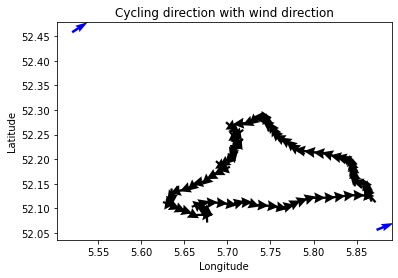

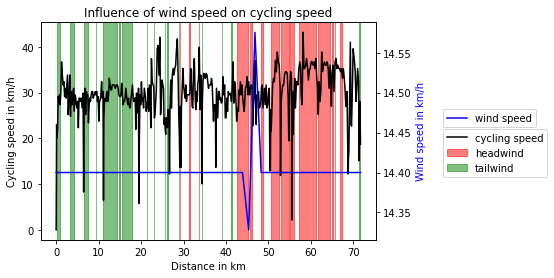

Tailwind percentage of activity: 17.62%
Headwind percentage of activity: 23.81%


In [29]:
page = 3     #7
activity_num = 0    #2
frequency = 20
spans_headwind, spans_tailwind = determine_headwind_tailwind_periods(page, activity_num, frequency)  #calling function can take a couple of minutes based on the frequency and the length of the activity!

plot_cycling_path_for_single_activity(page, activity_num, frequency = 100)
plot_headwind_tailwind_periods_for_single_activity(spans_headwind, spans_tailwind)
calculate_pct_of_headwind_tailwind(spans_headwind, spans_tailwind)